In [1]:
%matplotlib inline
import matplotlib.pyplot as plt      

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam

import hyperparams as hp
from datasets import LJSpeechDataset, collate_fn
from visualize import show_spectrogram
from audio import wav_to_spectrogram
from text import text_to_sequence, sequence_to_text
from models import MelSpectrogramNet

In [2]:
PATH = '/home/austin/data/tacotron/LJSpeech-1.0'

In [3]:
dataset = LJSpeechDataset(path=PATH, text_transforms=text_to_sequence,
                                     audio_transforms=wav_to_spectrogram)

In [4]:
text, audio = dataset[0]

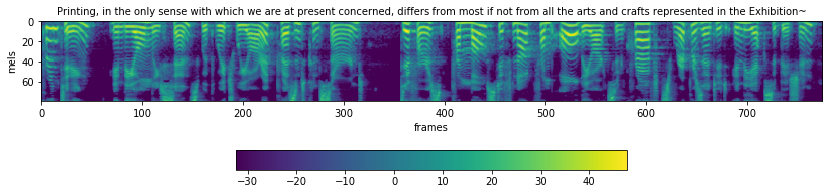

In [5]:
show_spectrogram(audio.T, sequence_to_text(text))

In [6]:
melnet = MelSpectrogramNet()
melnet.cuda()

MelSpectrogramNet(
  (encoder): Encoder(
    (char_embedding): Embedding(66, 512, padding_idx=0)
    (conv1): ConvBlock(
      (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      (batch): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
      (dropout): Dropout(p=0.5)
      (relu): ReLU()
    )
    (conv2): ConvBlock(
      (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      (batch): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
      (dropout): Dropout(p=0.5)
      (relu): ReLU()
    )
    (conv3): ConvBlock(
      (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      (batch): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
      (dropout): Dropout(p=0.5)
      (relu): ReLU()
    )
    (birnn): GRU(512, 256, dropout=0.1, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): PreNet(
      (fc1): Linear(in_features=80, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_fe

In [7]:
def train(model, optimizer, dataset, num_epochs, batch_size=1):
    model.train()
    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    for epoch in range(num_epochs):
        total_loss = 0
        for b, (text_batch, audio_batch, text_lengths, audio_lenghts) in enumerate(loader):
            text = Variable(text_batch).cuda()
            targets = Variable(audio_batch, requires_grad=False).cuda()
            
            #  create stop targets
            stop_targets = torch.zeros(targets.size(1), targets.size(0))
            for i in range(len(stop_targets)):
                stop_targets[i, audio_lenghts[i]-1] = 1
            stop_targets = Variable(stop_targets, requires_grad=False).cuda()

            optimizer.zero_grad()
            outputs, stop_tokens, attention = model(text, targets)
            spec_loss = F.mse_loss(outputs, targets)
            stop_loss = F.binary_cross_entropy_with_logits(stop_tokens, stop_targets)
            loss = spec_loss + stop_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.data[0]
            if b % 20 == 0 and b != 0:
                total_loss = total_loss / 100
                print("[%d][loss:%5.2f]" %
                  (b, total_loss))
                total_loss = 0

In [8]:
optimizer = Adam(melnet.parameters())

In [ ]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
train(melnet, optimizer, dataset, 1)

[20][loss:53.01]
[40][loss:23.90]
[60][loss:16.61]
[80][loss:14.48]
[100][loss:13.15]
[120][loss:12.97]
[140][loss:13.03]
[160][loss:13.03]
[180][loss:12.69]
[200][loss:11.68]
[220][loss:10.74]
[240][loss:10.75]
[260][loss:10.59]
[280][loss:10.54]
[300][loss:10.67]
[320][loss:10.55]
[340][loss:10.64]
[360][loss:10.35]
[380][loss: 9.92]
[400][loss:10.37]
[420][loss:10.86]
[440][loss:10.92]
[460][loss:10.95]
[480][loss:10.64]
[500][loss:11.14]
[520][loss:10.99]
[540][loss:11.47]
[560][loss:11.09]
[580][loss:10.77]
[600][loss:10.46]
[620][loss:10.16]
[640][loss: 9.92]
